[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [9]:
#import os
#import json
import numpy as np 
#import pandas as pd 

#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
#from pycocotools.coco import COCO
#import fiftyone as fo
#import time
#import torch
#import torchvision
#from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
#import cv2

In [3]:

import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

## Обучение модели

In [4]:
class RTSD_dataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        img = np.array(img)

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])      
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)       
        
        if self.transforms is not None:
            transform = self.transforms
            transformed = transform(image=img, bboxes=boxes, labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
        img = img/255
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [10]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
    # Send train=True fro training transforms and False for val/test transforms
def get_transform(train=False):
    if train==True:
        return A.Compose([A.HorizontalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          # ToTensorV2 converts image to pytorch tensor without div by 255
                          ToTensorV2(p=1.0)],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        




    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

#transform = A.Compose([
#    #A.RandomCrop(width=256, height=256),
#    A.HorizontalFlip(p=0.5),
#    A.RandomBrightnessContrast(p=0.2),
#])

In [11]:
# path to your own data and coco file
train_data_dir = 'data'
train_coco = 'data/train_anno_reduced_bin_class.json'

# create own Dataset
my_dataset = RTSD_dataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform(train=True)
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 8

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          #num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [12]:
my_dataset.__getitem__(0)[0].shape

torch.Size([3, 720, 1280])

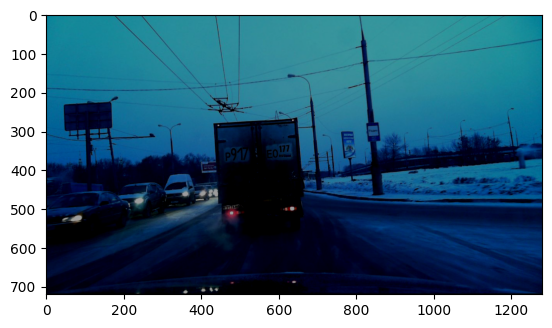

In [13]:
a, b = my_dataset.__getitem__(0)
repaired = a.permute(1, 2, 0).detach().numpy()
repaired = repaired*255
repaired = repaired.astype(np.uint8)
plt.imshow(repaired)

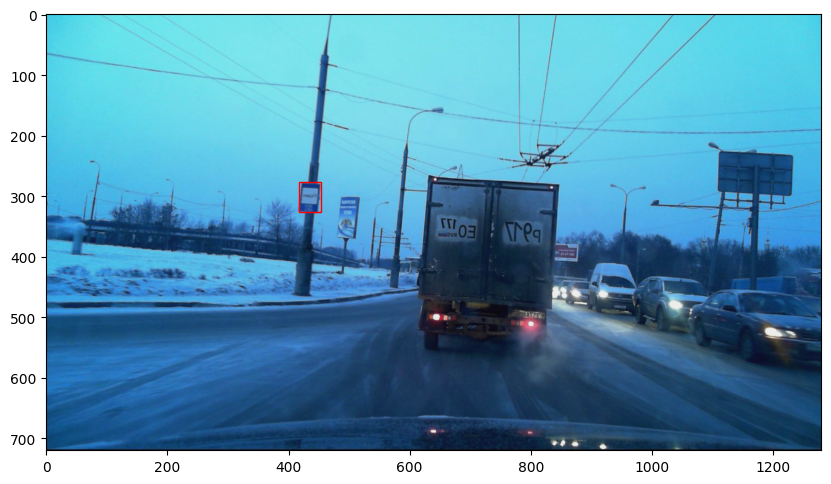

In [14]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
a, b = my_dataset.__getitem__(0)
repaired = a.permute(1, 2, 0).detach().numpy()
repaired = repaired*255
repaired = repaired.astype(np.uint8)
plot_img_bbox(repaired, b)

In [15]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps')

# DataLoader is iterable over Dataset
#for imgs, annotations in data_loader:
#    imgs = list(img.to(device) for img in imgs)
#    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
#    print(annotations)

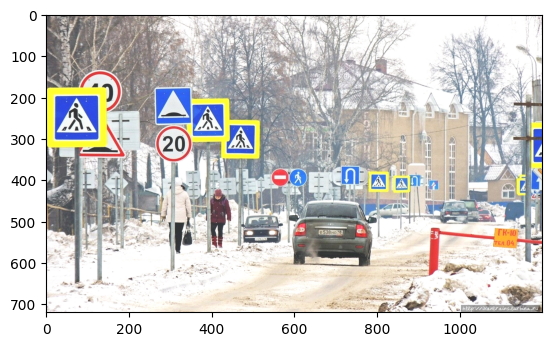

In [16]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
])
pillow_image = Image.open("data/image_for_predict/image2.jpg")
image = np.array(pillow_image)
transformed_image = transform(image=image)['image']
plt.imshow(transformed_image)

In [270]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
pillow_image = Image.open("data/image_for_predict/image2.jpg")
image = np.array(pillow_image)

bboxes = [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
category_ids = []
for i in range(len(bboxes)):
    category_ids.append(1)

#category_id_to_name = {17: 'cat', 18: 'dog'}

transform = A.Compose(
    [A.HorizontalFlip(p=0.5), ToTensorV2(p=1.0) ],
    
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
display(transformed_image)
display(transformed_bboxes)

tensor([[[213, 183, 204,  ..., 185, 249, 252],
         [211, 176, 211,  ..., 178, 251, 254],
         [227, 185, 187,  ..., 170, 252, 254],
         ...,
         [102,  98, 111,  ..., 198, 209, 205],
         [132, 126, 121,  ..., 197, 192, 190],
         [134, 146, 136,  ..., 221, 215, 233]],

        [[216, 185, 204,  ..., 187, 251, 254],
         [214, 178, 211,  ..., 180, 251, 254],
         [228, 186, 187,  ..., 170, 252, 254],
         ...,
         [ 83,  79,  92,  ..., 193, 204, 200],
         [113, 107, 102,  ..., 193, 188, 185],
         [115, 127, 118,  ..., 217, 211, 229]],

        [[209, 180, 204,  ..., 184, 248, 249],
         [207, 173, 211,  ..., 179, 249, 252],
         [222, 181, 187,  ..., 170, 250, 252],
         ...,
         [ 66,  64,  77,  ..., 190, 201, 197],
         [ 98,  92,  87,  ..., 190, 185, 182],
         [100, 112, 104,  ..., 214, 208, 226]]], dtype=torch.uint8)

[(1047.25, 138.95, 147.08999999999992, 164.88),
 (700.5, 80.84, 132.80000000000007, 181.84)]

In [11]:
import albumentations as A
import cv2


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))


pillow_image = Image.open("data/image_for_predict/image2.jpg")
image = np.array(pillow_image)


bboxes = [
    [23, 74, 295, 388],
    [377, 294, 252, 161],
    [333, 421, 49, 49,],
]

category_ids = [1, 1, 1]
category_id_to_name = {1: 'sign'}

transformed = transform(image=image, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

ValueError: Your 'label_fields' are not valid - them must have same names as params in dict

In [218]:
transformed_bboxes

[(882.0, 74.0, 295.0, 388.00000000000006, '1'),
 (571.0, 294.0, 252.0, 161.0, '1'),
 (818.0, 421.0, 48.999999999999886, 49.0, '1')]

In [8]:


bboxes = [
    [23, 74, 295, 388],
    [377, 294, 252, 161],
    [333, 421, 49, 49],
]
class_labels = ['1', '1', '1']
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
transformed = transform(image=image, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

ValueError: Your 'label_fields' are not valid - them must have same names as params in dict

In [39]:
img = 'data/image_for_predict/image1.jpg'
img = Image.open(img)
transforms=get_transform('train')

img = transforms(img)
img.shape

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

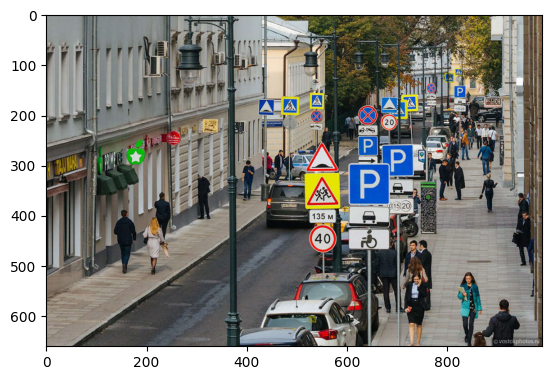

In [85]:
repaired = img.permute(1, 2, 0).detach().numpy()
repaired = repaired*255
repaired = repaired.astype(np.uint8)
plt.imshow(repaired)

In [54]:
test = my_dataset.__getitem__(1)[0].permute(1, 2, 0).detach().numpy()
test = test*255
test = test.astype(np.uint8)
test.reshape(720, 1280, 3)
display(test.shape)
test

(720, 1280, 3)

array([[[ 68, 219, 250],
        [ 68, 219, 250],
        [ 68, 219, 248],
        ...,
        [ 57, 211, 245],
        [ 55, 209, 245],
        [ 53, 207, 243]],

       [[ 66, 217, 248],
        [ 66, 217, 248],
        [ 66, 217, 246],
        ...,
        [ 59, 213, 247],
        [ 58, 212, 248],
        [ 56, 210, 246]],

       [[ 64, 217, 248],
        [ 64, 217, 248],
        [ 64, 218, 246],
        ...,
        [ 61, 214, 248],
        [ 61, 214, 248],
        [ 60, 213, 247]],

       ...,

       [[ 16,  57,  79],
        [ 17,  58,  80],
        [ 19,  60,  82],
        ...,
        [ 15,  73, 110],
        [ 15,  71, 108],
        [ 11,  69, 106]],

       [[ 30,  67,  86],
        [ 31,  68,  87],
        [ 32,  69,  88],
        ...,
        [ 24,  77, 109],
        [ 24,  74, 107],
        [ 19,  72, 104]],

       [[  0,   8,  27],
        [  0,   8,  27],
        [  0,   9,  28],
        ...,
        [  0,  12,  42],
        [  0,  11,  41],
        [  0,  11,  41]]

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [18]:
# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

AttributeError: 'list' object has no attribute 'to'

In [9]:
'''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            #'loss_train': train_loss,
            #'loss_val': val_loss
            #}, os.path.join(dataset_path, f'./checkpoints/model_detector_resnet50_{epoch}.pth'))
            }, f'./checkpoints/model_detector_resnet50_{epoch}.pth')'''

In [10]:
# path to your own data and coco file
test_data_dir = 'data'
test_coco = 'data/val_anno_bin_class.json'

# create own Dataset
my_dataset = RTSD_dataset(root=test_data_dir,
                          annotation=test_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 8

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          #num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


3507

{'id': 27338,
 'width': 1920,
 'height': 1080,
 'file_name': 'rtsd-frames/autosave13_04_2013_13_41_24_2.jpg'}

In [37]:
def get_prediction(img_path, img_name, threshold):
    model.eval()
    img = Image.open(os.path.join(img_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    prediction = model([img])
    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    pred_labels = list(prediction[0].get('labels').cpu().numpy())
    pred_scores = list(prediction[0].get('scores').detach().cpu().numpy())
    pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
    pred_labels = pred_labels[:pred_tr+1]
    pred_boxes = pred_boxes[:pred_tr+1]
    pred_scores = pred_scores[:pred_tr+1]
    
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return pred_boxes, pred_labels, pred_scores



img_path = 'data'
img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
threshold = 0.1
prediction = get_prediction(img_path, img_name, threshold)
prediction

TypeError: get_transform() missing 1 required positional argument: 'train'

In [14]:
def get_predict_anno(img_path, img_name, threshold):

    pred_boxes, pred_labels, pred_scores = get_prediction(img_path, img_name, threshold)

    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(img_path, img_name))
    transforms=get_transform()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(img_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()



    # загрузка изображения в fiftyone
    data_path = img_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(img_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)


    return anno


img_path = 'data'
#img_name = 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'
import random
with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
    val_anno = json.load(read_file)
read_file.close()
img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

threshold = 0.2
prediction_anno = get_predict_anno(img_path, img_name, threshold)

IndexError: list index out of range

In [ ]:
torch.cuda.empty_cache()

In [16]:
img_path = 'data'
img_name = 'image_for_predict/image1.jpg'
threshold = 0.1
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [40.7ms elapsed, 0s remaining, 25.2 samples/s] 


 100% |█████████████████████| 1/1 [25.2ms elapsed, 0s remaining, 42.1 samples/s] 



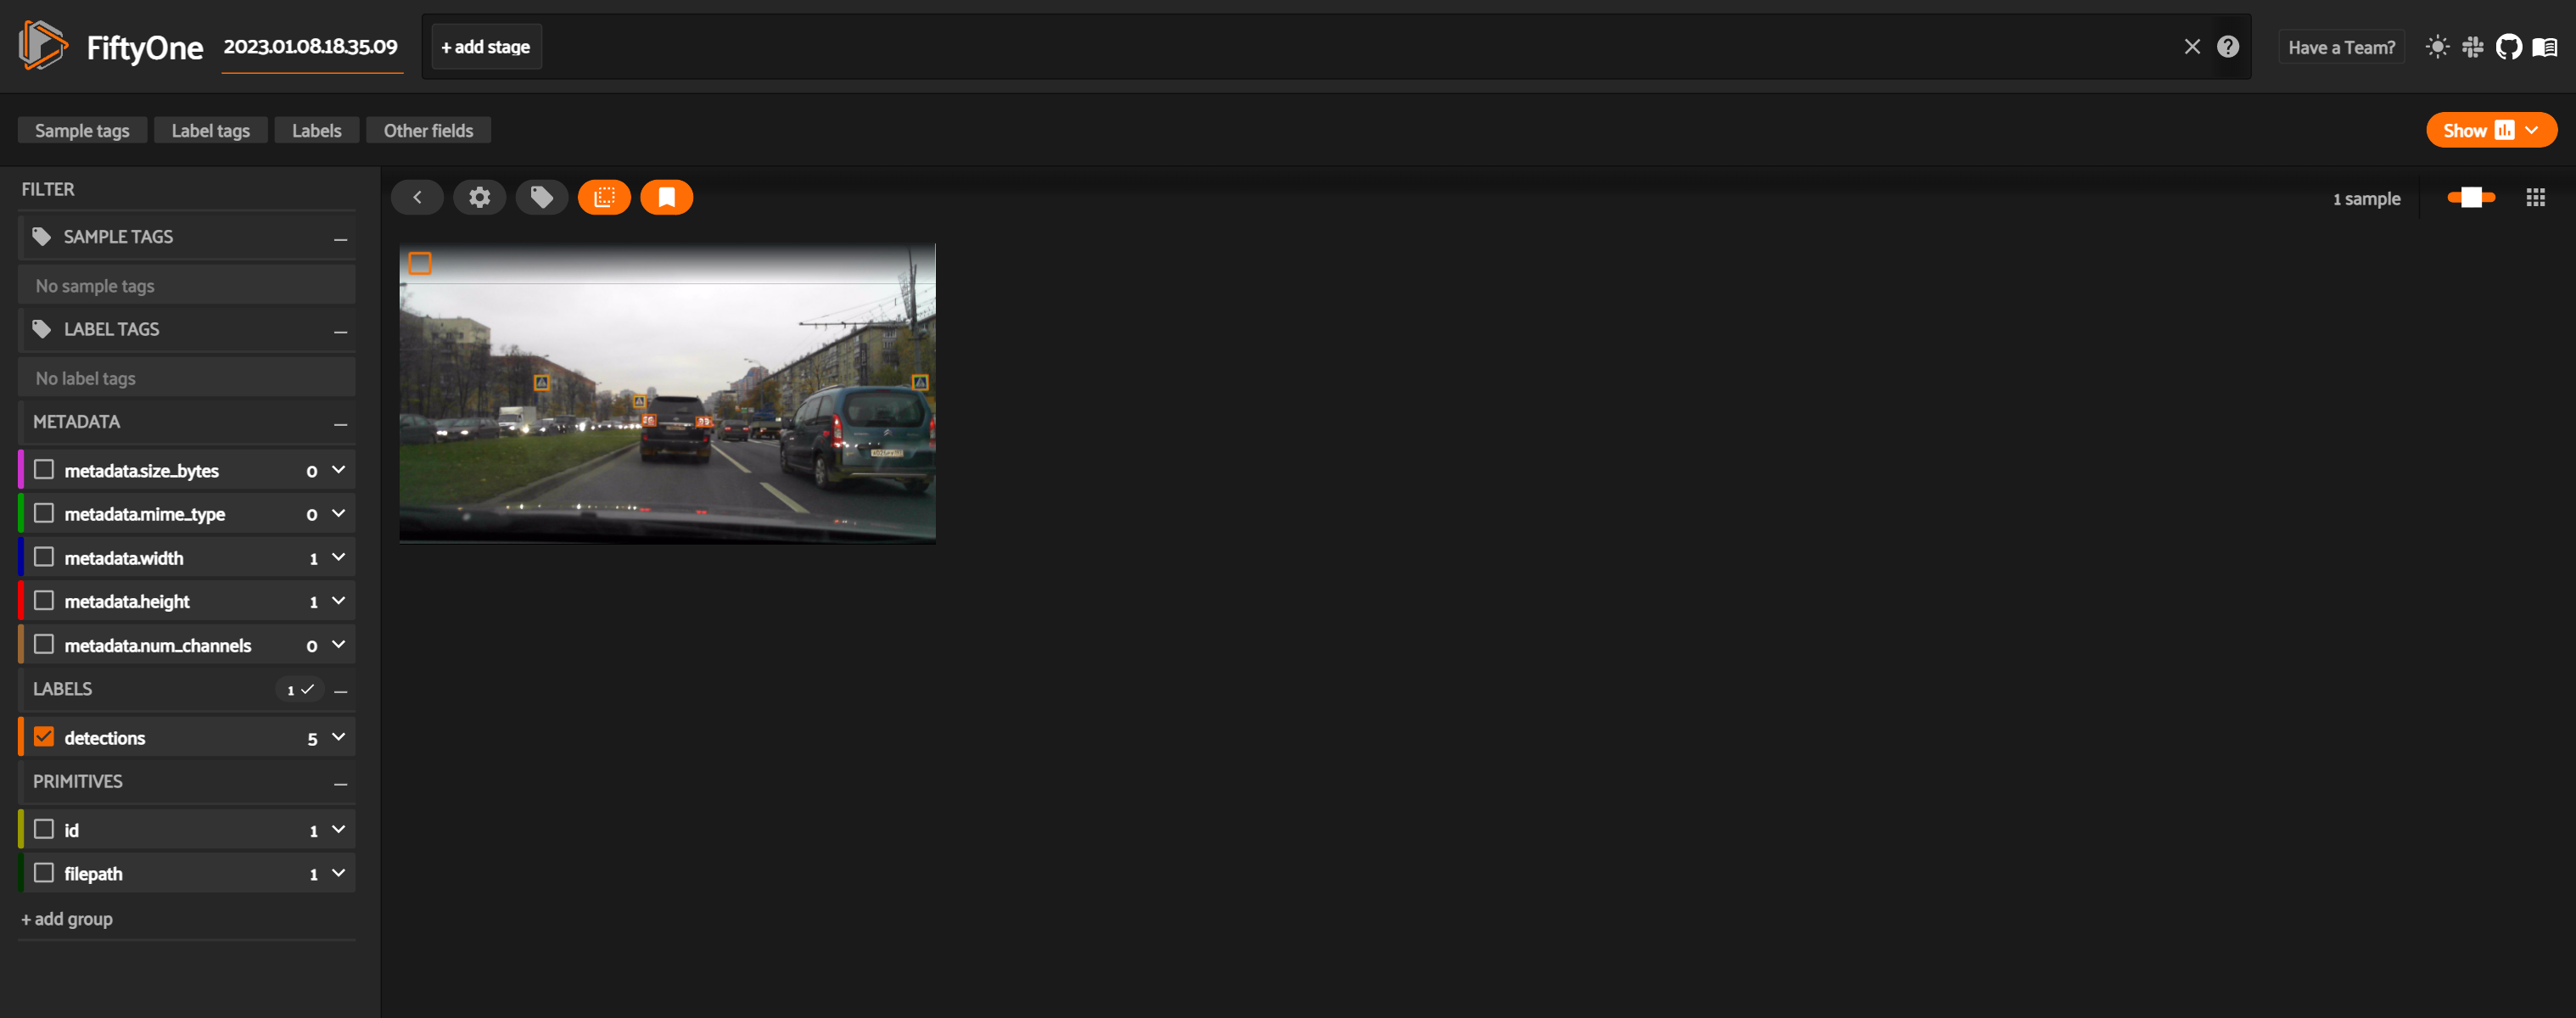


Could not connect session, trying again in 10 seconds



In [10]:
img_path = 'data'
img_name = 'image_for_predict/image2.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [17.9ms elapsed, 0s remaining, 60.0 samples/s] 



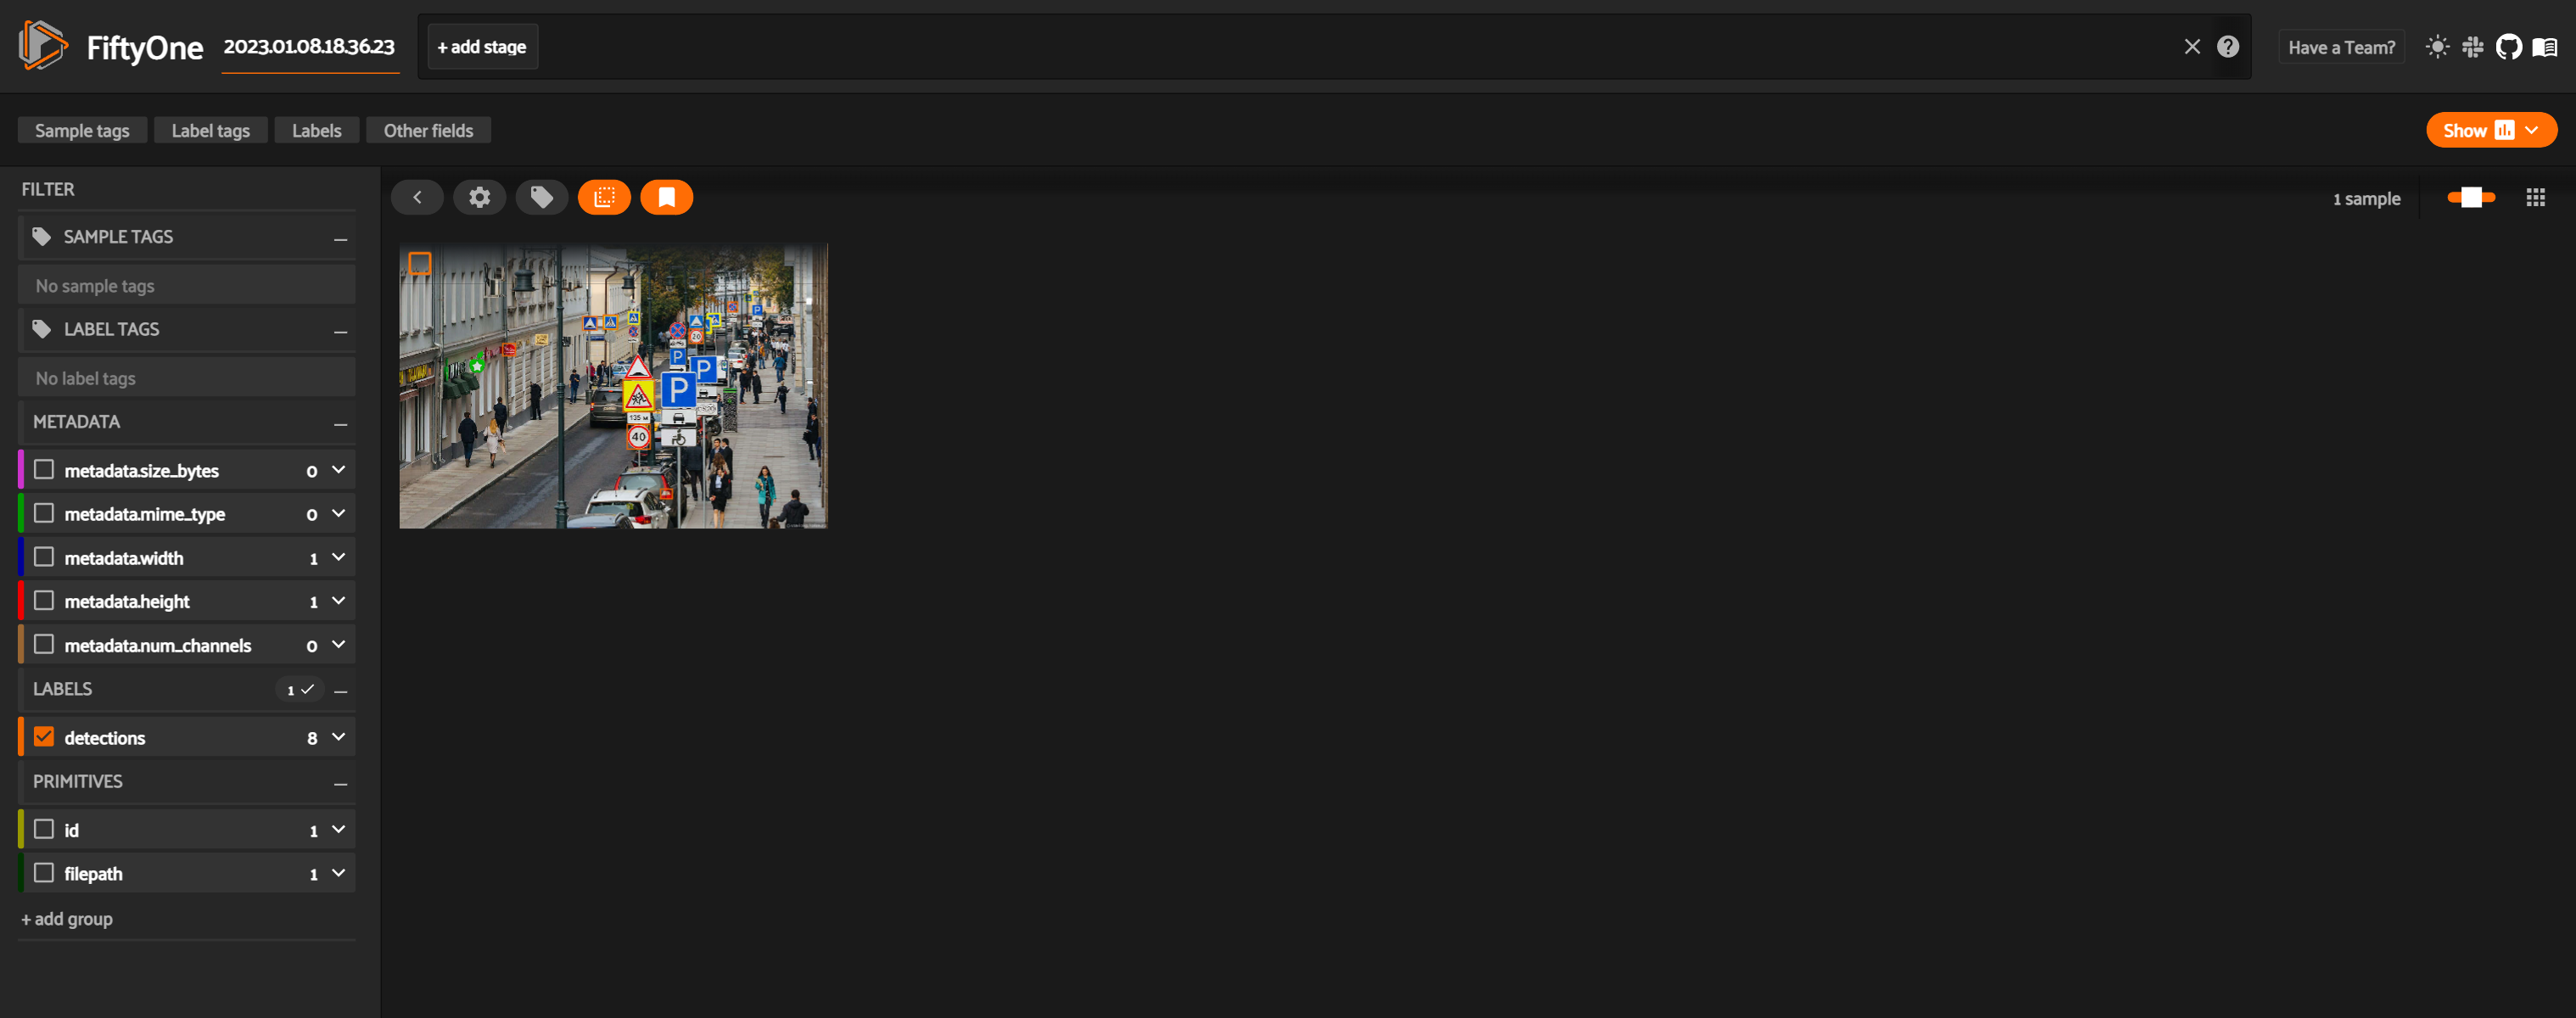


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [11]:
img_path = 'data'
img_name = 'image_for_predict/screen1.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)

 100% |█████████████████████| 1/1 [24.7ms elapsed, 0s remaining, 42.8 samples/s] 



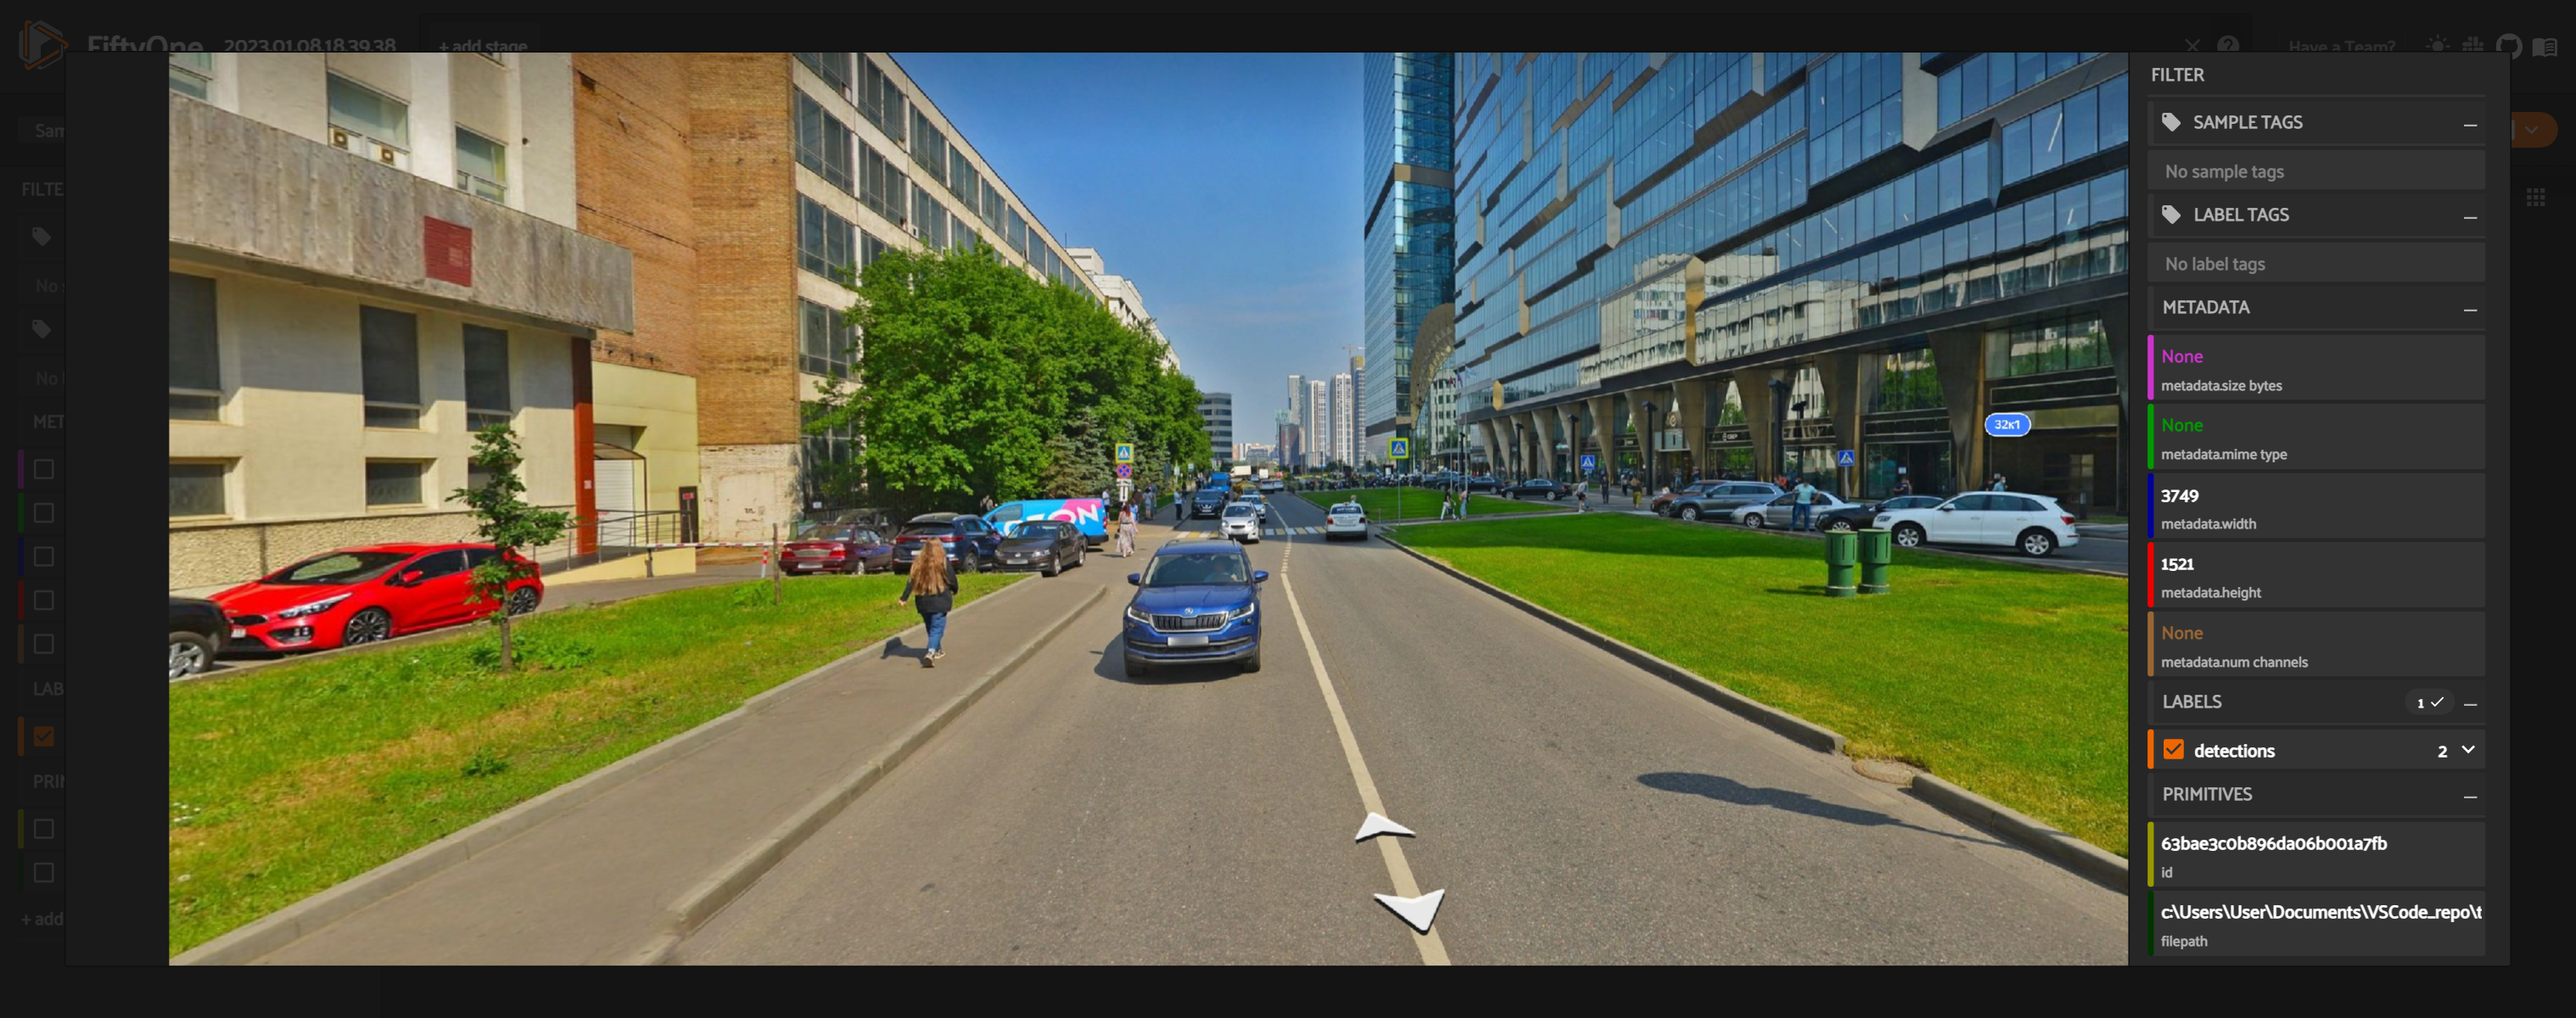

In [18]:
img_path = 'data'
img_name = 'image_for_predict/screen2.jpg'
threshold = 0.7
prediction_anno = get_predict_anno(img_path, img_name, threshold)